# Time series data prep and an LSTM example

Let us go through a **basic** LSTM  example based on a [publicly available property manintenance dataset](https://combed.github.io/).

**This is _not_ a full datascience project, only the demonstration of some data preparation and training concepts!**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Data prep

In [ ]:
!wget https://gitlab.com/andras.simonyi/10_days_AI_training_data/raw/master/Power.csv?inline=false -O Power.csv

--2022-11-11 16:18:36--  https://gitlab.com/andras.simonyi/10_days_AI_training_data/raw/master/Power.csv?inline=false
Resolving gitlab.com (gitlab.com)... 172.65.251.78, 2606:4700:90:0:f22e:fbec:5bed:a9b9
Connecting to gitlab.com (gitlab.com)|172.65.251.78|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3128452 (3.0M) [application/octet-stream]
Saving to: ‘Power.csv’

Power.csv           100%[===================>]   2.98M  --.-KB/s    in 0.1s    

2022-11-11 16:18:36 (28.2 MB/s) - ‘Power.csv’ saved [3128452/3128452]



In [ ]:
# Source: Dataset / Academic / Power sockets / 3

df = pd.read_csv("Power.csv", header=None)
df.columns = ["Timestamp","Power"]
df["Timestamp"] = df["Timestamp"] / 1e10
df.head()

,Timestamp,Power
0,140.159520,58.694874
1,140.159523,58.465698
2,140.159526,58.090099
3,140.159529,58.260864
4,140.159532,58.002567


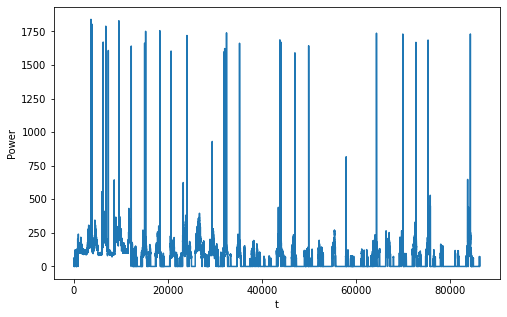

In [ ]:
df["Power"].plot(figsize=(8,5), ylabel="Power", xlabel="t")
plt.show()

What is autocorrelation, really:

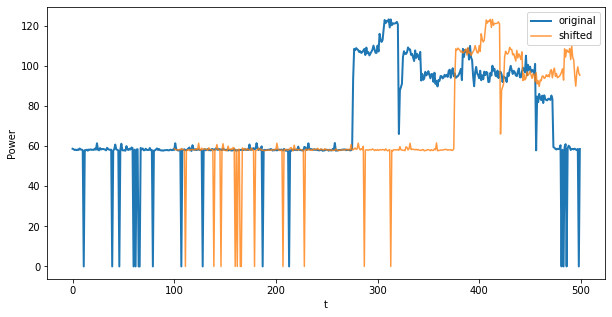

In [ ]:
## lag-100:
df["Power"].iloc[:500].plot(figsize=(10,5), ylabel="Power", xlabel="t", linewidth=2, label="original")
df["Power"].shift(100).iloc[:500].plot(ylabel="Power", xlabel="t", alpha=0.8, label="shifted")
plt.legend()
plt.show()

In [ ]:
## autocorr. lag-3:
df["Power"].shift(3).corr(df["Power"])

0.7603204132966188

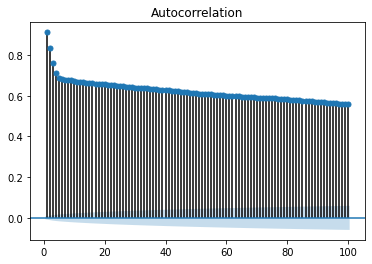

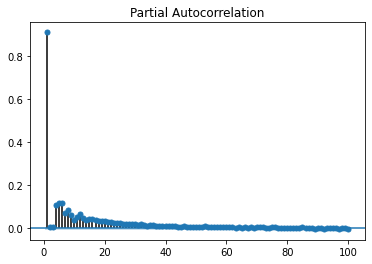

---
CPU times: user 5.46 s, sys: 3.68 s, total: 9.14 s
Wall time: 8.33 s


In [ ]:
%%time
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

plot_acf(df.Power, lags=100, zero=False)
plot_pacf(df.Power, lags=100, zero=False)
plt.show()
print("---")

### Basic prep

IMPORTANT: this is just for expository purposes, to see how to prepare multivariate time series for ML models, incl. recurrent NN's. In a real project, for this particular dataset, the settings/setup we use here for data prep. & co is not what we would ideally choose (e.g. time window of 10 is way too small).

In [ ]:
df.round(6)

,Timestamp,Power
0,140.159520,58.694874
1,140.159523,58.465698
2,140.159526,58.090099
3,140.159529,58.260864
4,140.159532,58.002567
...,...,...
86195,140.418708,0.000000
86196,140.418711,0.000000
86197,140.418714,0.000000
86198,140.418717,0.000000


In [ ]:
VALID_AND_TEST_SIZE = 0.1
TIME_WINDOW=10
FORECAST_DISTANCE=3

In [ ]:
targetcol = "Power"
targetcol_series = df[targetcol]

Train-test split

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_else, targetcol_series_train, targetcol_series_else = train_test_split(df, 
                                   targetcol_series, 
                                   test_size=VALID_AND_TEST_SIZE*2, 
                                   shuffle=False)
X_valid, X_test, targetcol_series_valid, targetcol_series_test = train_test_split(X_else, targetcol_series_else, test_size=0.5, shuffle=False)

In [ ]:
print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)
print()
print(targetcol_series_train.shape)
print(targetcol_series_valid.shape)
print(targetcol_series_test.shape)

(68960, 2)
(8620, 2)
(8620, 2)

(68960,)
(8620,)
(8620,)


### Sliding window

Fitting X and y onto the time series: 
* first X sample has to fit TIME_WINDOW at the beginning
* last y sample has to fit FORECAST_DISTANCE-1 into the future 
    > * If `FORECAST_DISTANCE == 1`, then we just take the target column, nonshifted.
    > * If `FORECAST_DISTANCE == 2`, then we just take the target column, shifted BACK by 1 (=next row's value, `shift(-1)`), etc.

In [ ]:
def sliding_window_2D_from_df(df, targetcol_series, TIME_WINDOW, FORECAST_DISTANCE):
    X_df = pd.concat([df.shift(i) for i in range(1,TIME_WINDOW+1)], axis=1)\
                      .iloc[TIME_WINDOW : len(df) - FORECAST_DISTANCE + 1]
    X_df.columns = pd.MultiIndex.from_product([range(1,TIME_WINDOW+1), df.columns])
    X_df.rename_axis(["lag", "variable"], axis=1, inplace=True)

    y_series = targetcol_series.shift( -FORECAST_DISTANCE + 1 )\
                      .iloc[ TIME_WINDOW : len(df) - FORECAST_DISTANCE + 1 ]
    return X_df, y_series

In [ ]:
def spot_check_sliding_window_2D(X_df, y_series, df, target_series, FORECAST_DISTANCE=1):
    TIME_WINDOW = X_df.shape[1] // df.shape[1]
    display(X_df.head(1).iloc[:,[*list(range(2*df.shape[1])), *list(range(-2*df.shape[1],0))]])
    print("The following should be the first two lagged values:")
    display(df.iloc[:TIME_WINDOW].tail(2))
    print("The following should be the last two lagged values:")
    display(df.head(2))

    print(f"\nThe target (FORECAST_DISTANCE={FORECAST_DISTANCE}):")
    display(y_series.iloc[:10].to_frame().T)
    print(f"The actual values from the end of the first time window (TIME_WINDOW={TIME_WINDOW}):")
    display(target_series.iloc[TIME_WINDOW:].iloc[:FORECAST_DISTANCE+9].to_frame().T)

In [ ]:
X_df_train, y_train = sliding_window_2D_from_df(X_train, targetcol_series_train, TIME_WINDOW, FORECAST_DISTANCE)
X_df_valid, y_valid = sliding_window_2D_from_df(X_valid, targetcol_series_valid, TIME_WINDOW, FORECAST_DISTANCE)
X_df_test, y_test = sliding_window_2D_from_df(X_test, targetcol_series_test, TIME_WINDOW, FORECAST_DISTANCE)

In [ ]:
## check, just to be on the safe side...

assert y_train.notna().all()
assert y_valid.notna().all()
assert y_test.notna().all()

assert X_train.notna().all().all()
assert X_valid.notna().all().all()
assert X_test.notna().all().all()

Spot-checking...

In [ ]:
spot_check_sliding_window_2D(X_df_train, y_train, X_train, targetcol_series_train, FORECAST_DISTANCE)

lag               1                      2                      9              \
variable   Timestamp      Power   Timestamp      Power   Timestamp      Power   
10        140.159547  58.282005  140.159544  58.303482  140.159523  58.465698   

lag              10             
variable  Timestamp      Power  
10        140.15952  58.694874

The following should be the first two lagged values:


,Timestamp,Power
8,140.159544,58.303482
9,140.159547,58.282005


The following should be the last two lagged values:


,Timestamp,Power
0,140.159520,58.694874
1,140.159523,58.465698



The target (FORECAST_DISTANCE=3):


,10,11,12,13,14,15,16,17,18,19
Power,58.011189,58.015461,58.246803,57.751892,58.302925,58.184608,58.397438,58.150204,58.215015,58.166397


The actual values from the end of the first time window (TIME_WINDOW=10):


,10,11,12,13,14,15,16,17,18,19,20,21
Power,57.936417,1.600000e-17,58.011189,58.015461,58.246803,57.751892,58.302925,58.184608,58.397438,58.150204,58.215015,58.166397


### Sliding window into (samples, timesteps, variables) shaped array


In [ ]:
## where we are at...: something we can feed into generic models (e.g., feedfwd NN's, sklearn models like RF...)
X_df_train

lag               1                         2                         3   \
variable   Timestamp         Power   Timestamp         Power   Timestamp   
10        140.159547  5.828201e+01  140.159544  5.830348e+01  140.159541   
11        140.159550  5.793642e+01  140.159547  5.828201e+01  140.159544   
12        140.159553  1.600000e-17  140.159550  5.793642e+01  140.159547   
13        140.159556  5.801119e+01  140.159553  1.600000e-17  140.159550   
14        140.159559  5.801546e+01  140.159556  5.801119e+01  140.159553   
...              ...           ...         ...           ...         ...   
68953     140.366852  1.600000e-17  140.366849  1.600000e-17  140.366846   
68954     140.366855  1.600000e-17  140.366852  1.600000e-17  140.366849   
68955     140.366858  1.600000e-17  140.366855  1.600000e-17  140.366852   
68956     140.366861  1.600000e-17  140.366858  1.600000e-17  140.366855   
68957     140.366864  1.600000e-17  140.366861  1.600000e-17  140.366858   

lag                             4                         5                 \
variable         Power   Timestamp         Power   Timestamp         Power   
10        5.884218e+01  140.159538  5.811860e+01  140.159535  5.831047e+01   
11        5.830348e+01  140.159541  5.884218e+01  140.159538  5.811860e+01   
12        5.828201e+01  140.159544  5.830348e+01  140.159541  5.884218e+01   
13        5.793642e+01  140.159547  5.828201e+01  140.159544  5.830348e+01   
14        1.600000e-17  140.159550  5.793642e+01  140.159547  5.828201e+01   
...                ...         ...           ...         ...           ...   
68953     1.600000e-17  140.366843  1.600000e-17  140.366840  1.600000e-17   
68954     1.600000e-17  140.366846  1.600000e-17  140.366843  1.600000e-17   
68955     1.600000e-17  140.366849  1.600000e-17  140.366846  1.600000e-17   
68956     1.600000e-17  140.366852  1.600000e-17  140.366849  1.600000e-17   
68957     1.600000e-17  140.366855  1.600000e-17  140.366852  1.600000e-17   

lag               6                         7                         8   \
variable   Timestamp         Power   Timestamp         Power   Timestamp   
10        140.159532  5.800257e+01  140.159529  5.826086e+01  140.159526   
11        140.159535  5.831047e+01  140.159532  5.800257e+01  140.159529   
12        140.159538  5.811860e+01  140.159535  5.831047e+01  140.159532   
13        140.159541  5.884218e+01  140.159538  5.811860e+01  140.159535   
14        140.159544  5.830348e+01  140.159541  5.884218e+01  140.159538   
...              ...           ...         ...           ...         ...   
68953     140.366837  1.600000e-17  140.366834  1.600000e-17  140.366831   
68954     140.366840  1.600000e-17  140.366837  1.600000e-17  140.366834   
68955     140.366843  1.600000e-17  140.366840  1.600000e-17  140.366837   
68956     140.366846  1.600000e-17  140.366843  1.600000e-17  140.366840   
68957     140.366849  1.600000e-17  140.366846  1.600000e-17  140.366843   

lag                             9                         10                
variable         Power   Timestamp         Power   Timestamp         Power  
10        5.809010e+01  140.159523  5.846570e+01  140.159520  5.869487e+01  
11        5.826086e+01  140.159526  5.809010e+01  140.159523  5.846570e+01  
12        5.800257e+01  140.159529  5.826086e+01  140.159526  5.809010e+01  
13        5.831047e+01  140.159532  5.800257e+01  140.159529  5.826086e+01  
14        5.811860e+01  140.159535  5.831047e+01  140.159532  5.800257e+01  
...                ...         ...           ...         ...           ...  
68953     1.600000e-17  140.366828  1.600000e-17  140.366825  1.600000e-17  
68954     1.600000e-17  140.366831  1.600000e-17  140.366828  1.600000e-17  
68955     1.600000e-17  140.366834  1.600000e-17  140.366831  1.600000e-17  
68956     1.600000e-17  140.366837  1.600000e-17  140.366834  1.600000e-17  
68957     1.600000e-17  140.366840  1.600000e-17  140.366837  1.600000e-17  

[6894

In [ ]:
def rolled_X_from_2D_sliding_window_df(X_df, timesteps):
    X_rolled = X_df.values.reshape(X_df.shape[0], timesteps, -1)
    return X_rolled

In [ ]:
X_rolled_train = rolled_X_from_2D_sliding_window_df(X_df_train, TIME_WINDOW)
X_rolled_valid = rolled_X_from_2D_sliding_window_df(X_df_valid, TIME_WINDOW)
X_rolled_test = rolled_X_from_2D_sliding_window_df(X_df_test, TIME_WINDOW)

In [ ]:
print(y_train.shape)
print(X_df_train.shape)
print(X_rolled_train.shape)

print()

print(y_test.shape)
print(X_df_test.shape)
print(X_rolled_test.shape)

(68948,)
(68948, 20)
(68948, 10, 2)

(8608,)
(8608, 20)
(8608, 10, 2)


Automated checking of first samples...

In [ ]:
def autocheck_first_sample(orig_df, X_rolled, targetcol_series, y):
    np.testing.assert_equal(orig_df[:TIME_WINDOW].iloc[::-1].values,
                            X_rolled[0])
    np.testing.assert_equal(pd.Series(targetcol_series).iloc[TIME_WINDOW-1+FORECAST_DISTANCE],
                            pd.Series(y).iloc[0])

In [ ]:
autocheck_first_sample(X_train, X_rolled_train, targetcol_series_train, y_train)
autocheck_first_sample(X_valid, X_rolled_valid, targetcol_series_valid, y_valid)
autocheck_first_sample(X_test, X_rolled_test, targetcol_series_test, y_test)

Spot checking...

In [ ]:
def spot_check_3D_Xarray(X_rolled, X_df):
    for sample_idx in [0, 1, -2, -1]:
        print(f"SAMPLE NR. {sample_idx}:")
        print("In derived and in rolled data, for time steps 0,1,...-2,-1:")
        display( X_df.iloc[[sample_idx], [0, 1, 2, 3, -4,-3, -2, -1]].round(4) )
        print(X_rolled[sample_idx][0].round(4), X_rolled[sample_idx][1].round(4), 
            "...",  X_rolled[sample_idx][-2].round(4),  X_rolled[sample_idx][-1].round(4))
        print("\n")

In [ ]:
X_rolled_train[0][-1].round(4)

array([140.1595,  58.6949])

In [ ]:
spot_check_3D_Xarray(X_rolled_train, X_df_train)

SAMPLE NR. 0:
In derived and in rolled data, for time steps 0,1,...-2,-1:


lag             1                 2                  9                  10  \
variable Timestamp   Power Timestamp    Power Timestamp    Power Timestamp   
10        140.1595  58.282  140.1595  58.3035  140.1595  58.4657  140.1595   

lag                
variable    Power  
10        58.6949

[140.1595  58.282 ] [140.1595  58.3035] ... [140.1595  58.4657] [140.1595  58.6949]


SAMPLE NR. 1:
In derived and in rolled data, for time steps 0,1,...-2,-1:


lag             1                  2                 9                  10  \
variable Timestamp    Power Timestamp   Power Timestamp    Power Timestamp   
11        140.1596  57.9364  140.1595  58.282  140.1595  58.0901  140.1595   

lag                
variable    Power  
11        58.4657

[140.1596  57.9364] [140.1595  58.282 ] ... [140.1595  58.0901] [140.1595  58.4657]


SAMPLE NR. -2:
In derived and in rolled data, for time steps 0,1,...-2,-1:


lag             1               2               9               10      
variable Timestamp Power Timestamp Power Timestamp Power Timestamp Power
68956     140.3669   0.0  140.3669   0.0  140.3668   0.0  140.3668   0.0

[140.3669   0.    ] [140.3669   0.    ] ... [140.3668   0.    ] [140.3668   0.    ]


SAMPLE NR. -1:
In derived and in rolled data, for time steps 0,1,...-2,-1:


lag             1               2               9               10      
variable Timestamp Power Timestamp Power Timestamp Power Timestamp Power
68957     140.3669   0.0  140.3669   0.0  140.3668   0.0  140.3668   0.0

[140.3669   0.    ] [140.3669   0.    ] ... [140.3668   0.    ] [140.3668   0.    ]




## Building LSTM networks

In [ ]:
## Quick data prep that is intuitively a good starting point

VALID_AND_TEST_SIZE = 0.1
TIME_WINDOW=100
FORECAST_DISTANCE=1

targetcol = "Power"
targetcol_series = df[targetcol]

## train valid test split
X_train, X_else, targetcol_series_train, targetcol_series_else = train_test_split(df[["Power"]], 
                                   targetcol_series, 
                                   test_size=VALID_AND_TEST_SIZE*2, 
                                   shuffle=False)
X_valid, X_test, targetcol_series_valid, targetcol_series_test = train_test_split(X_else, targetcol_series_else, test_size=0.5, shuffle=False)

## sliding window
X_df_train, y_train = sliding_window_2D_from_df(X_train, targetcol_series_train, TIME_WINDOW, FORECAST_DISTANCE)
X_df_valid, y_valid = sliding_window_2D_from_df(X_valid, targetcol_series_valid, TIME_WINDOW, FORECAST_DISTANCE)
X_df_test, y_test = sliding_window_2D_from_df(X_test, targetcol_series_test, TIME_WINDOW, FORECAST_DISTANCE)

## for lstm
X_rolled_train = rolled_X_from_2D_sliding_window_df(X_df_train, TIME_WINDOW)
X_rolled_valid = rolled_X_from_2D_sliding_window_df(X_df_valid, TIME_WINDOW)
X_rolled_test = rolled_X_from_2D_sliding_window_df(X_df_test, TIME_WINDOW)

autocheck_first_sample(X_train, X_rolled_train, targetcol_series_train, y_train)
autocheck_first_sample(X_valid, X_rolled_valid, targetcol_series_valid, y_valid)
autocheck_first_sample(X_test, X_rolled_test, targetcol_series_test, y_test)

print(X_rolled_train.shape)

(68860, 100, 1)


###### Aside: About the LSTM layer in keras: return_sequences vs. return_state

In [ ]:
from tensorflow.keras.layers import LSTM
from tensorflow.keras import backend as be
import tensorflow as tf

## we use 10 samples
## and 4 units (hidden state is 4-long for each time step)

tf.random.set_seed(42)
be.clear_session()
input_layer = X_rolled_train[:10]

whole_seq_output, final_memory_state, final_carry_state =  LSTM(4, return_sequences=True, return_state=True)(input_layer)

tf.random.set_seed(42)
be.clear_session()
whole_seq_output2 =  LSTM(4, return_sequences=True, return_state=False)(input_layer)

tf.random.set_seed(42)
be.clear_session()
out_last =  LSTM(4, return_sequences=False, return_state=False)(input_layer)

tf.random.set_seed(42)
be.clear_session()
whole_seq_output3, final_memory_state3, final_carry_state3 =  LSTM(4, return_sequences=False, return_state=True)(input_layer)


print("return_sequences=True, return_state=True")
print(whole_seq_output.shape)
print(final_memory_state.shape)
print(final_carry_state.shape)

print()
print("return_sequences=True, return_state=False")
print(whole_seq_output2.shape)

print()
print("return_sequences=False, return_state=False")
print(out_last.shape)

print()
print("return_sequences=False, return_state=True")
print(whole_seq_output3.shape)
print(final_memory_state3.shape)
print(final_carry_state3.shape)



return_sequences=True, return_state=True
(10, 100, 4)
(10, 4)
(10, 4)

return_sequences=True, return_state=False
(10, 100, 4)

return_sequences=False, return_state=False
(10, 4)

return_sequences=False, return_state=True
(10, 4)
(10, 4)
(10, 4)


In [ ]:
print("For first sample...\n")
print("\treturn_sequences=True, return_state=True")
print("\tlast two time step hidden state output:", np.array(whole_seq_output[0][-2:]))
print("\tfinal hidden state (=output):", np.array(final_memory_state[0]))
print("\tfinal cell state:", np.array(final_carry_state[0]))

print()
print("\treturn_sequences=True, return_state=False")
print("\tlast two time step hidden state output:", np.array(whole_seq_output2[0][-2:]))

print()
print("\treturn_sequences=False, return_state=False")
print("\tfinal hidden state (=output):", np.array(out_last[0]))

print()
print("\treturn_sequences=False, return_state=True")
print("\thidden state:", np.array(whole_seq_output3[0]))
print("\tfinal hidden state (=output):", np.array(final_memory_state3[0]))
print("\tfinal cell state:", np.array(final_carry_state3[0]))



For first sample...

	return_sequences=True, return_state=True
	last two time step hidden state output: [[-8.7685328e-12 -7.5589114e-01  6.3318324e-01  9.9878609e-01]
 [-7.9254294e-12 -7.6086920e-01  6.3325518e-01  9.9904948e-01]]
	final hidden state (=output): [-7.925429e-12 -7.608692e-01  6.332552e-01  9.990495e-01]
	final cell state: [-0.9999923 -1.0707757  0.7547916  3.8255856]

	return_sequences=True, return_state=False
	last two time step hidden state output: [[-8.7685328e-12 -7.5589114e-01  6.3318324e-01  9.9878609e-01]
 [-7.9254294e-12 -7.6086920e-01  6.3325518e-01  9.9904948e-01]]

	return_sequences=False, return_state=False
	final hidden state (=output): [-7.925429e-12 -7.608692e-01  6.332552e-01  9.990495e-01]

	return_sequences=False, return_state=True
	hidden state: [-7.925429e-12 -7.608692e-01  6.332552e-01  9.990495e-01]
	final hidden state (=output): [-7.925429e-12 -7.608692e-01  6.332552e-01  9.990495e-01]
	final cell state: [-0.9999923 -1.0707757  0.7547916  3.8255856

###### Model definition

In [ ]:
#---- Hyperparams and settings ----

EPOCHS = 30
BATCH_SIZE = 200
LEARNING_RATE = 0.1
LSTM_CELL_SIZE = 300
LSTM_CELL_SIZE2 = 100

In [ ]:
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Dense, LSTM, Input
from tensorflow.keras import backend as be
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam

## number of input variables: the final dimension in the 3D prepared data (index 2)
column_count=X_rolled_train.shape[2]

be.clear_session()

model = Sequential()

### !!!return_sequences=True if recurrent layer follows
model.add( LSTM(LSTM_CELL_SIZE, return_sequences=True, input_shape=(TIME_WINDOW,column_count)))

### default return_sequences=False if Dense layer follows
model.add( LSTM(LSTM_CELL_SIZE2) )

### the output layer:
model.add(  Dense(1) )  ## Question: what is the activation here?

optimizer = Adam(learning_rate=LEARNING_RATE)

## remember, we're doing regression, so choose loss (and output layer) accordingly!
model.compile(loss='mean_squared_error', optimizer=optimizer)

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 300)           363600    
                                                                 
 lstm_1 (LSTM)               (None, 100)               160400    
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 524,101
Trainable params: 524,101
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
history = model.fit(x=X_rolled_train,
                    y=y_train, 
                    batch_size=BATCH_SIZE, 
                    validation_data=(X_rolled_valid,y_valid), 
                    epochs=EPOCHS,
                    verbose=1, 
                    shuffle=False,
                    )

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.legend()
plt.show()

In [ ]:
predictions = model.predict(X_rolled_test).flatten()

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(list(X_test[TIME_WINDOW:]), label="Test")
plt.plot(list(predictions), label="Predictions")
plt.legend()
plt.show()